In [ ]:
import keras
import pandas as pd
from tensorflow.keras.applications import MobileNetV2

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rufaeltekleab","key":"c2a0e3347fcee533e8a75ae360f6de47"}'}

# Task
Performing transfer learning using MobileNetV2 with default parameters on the Kaggle Dog Breed Identification dataset.

## Setup kaggle

Configure the Kaggle API to download the dataset.


In [ ]:
import os
import shutil

# Create the .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Copy the kaggle.json file
shutil.move('/content/kaggle.json', '/root/.kaggle/kaggle.json')

# Change permissions of kaggle.json
os.chmod('/root/.kaggle/kaggle.json', 0o600)

## Download and extract dataset

Download the dog breed identification dataset from Kaggle and extract the image files.


In [ ]:
import zipfile

!kaggle datasets download -d jessicali9530/stanford-dogs-dataset
os.makedirs('images', exist_ok=True)
with zipfile.ZipFile('stanford-dogs-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('images')
os.remove('stanford-dogs-dataset.zip')

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset
License(s): other
 85% 640M/750M [00:00<00:00, 1.66GB/s]
100% 750M/750M [00:00<00:00, 1.66GB/s]


## Prepare data

Load the labels, preprocess the images, and create data generators for training and validation.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Keep for potential future use or comparison
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import os

# Define image dimensions for MobileNetV2
img_width, img_height = 224, 224
batch_size = 32

# Load datasets directly from directories using image_dataset_from_directory
# This function infers labels from subdirectory names
train_ds = image_dataset_from_directory(
    '/content/images/images/Images/',
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

validation_ds = image_dataset_from_directory(
    '/content/images/images/Images/',
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    seed=42,
    validation_split=0.2,
    subset='validation'
)

# Get the class names
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names[:10]}...") # Print first 10 class names

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.
Number of classes: 120
Class names: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound']...


## Build the model
Load the pre-trained MobileNetV2 model and add a new classification layer.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the MobileNetV2 model with pre-trained weights on ImageNet, excluding the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a dense layer for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
!ls -R /content/

Streaming output truncated to the last 5000 lines.
n02089867_1048.jpg  n02089867_180.jpg	n02089867_2567.jpg  n02089867_3602.jpg
n02089867_1062.jpg  n02089867_1824.jpg	n02089867_2582.jpg  n02089867_3608.jpg
n02089867_1079.jpg  n02089867_183.jpg	n02089867_2596.jpg  n02089867_3679.jpg
n02089867_1082.jpg  n02089867_1863.jpg	n02089867_2602.jpg  n02089867_3726.jpg
n02089867_1105.jpg  n02089867_1882.jpg	n02089867_2614.jpg  n02089867_3727.jpg
n02089867_1133.jpg  n02089867_1912.jpg	n02089867_2653.jpg  n02089867_3784.jpg
n02089867_1208.jpg  n02089867_1918.jpg	n02089867_266.jpg   n02089867_3800.jpg
n02089867_1212.jpg  n02089867_1921.jpg	n02089867_2677.jpg  n02089867_3840.jpg
n02089867_1225.jpg  n02089867_1931.jpg	n02089867_2688.jpg  n02089867_3892.jpg
n02089867_1240.jpg  n02089867_1965.jpg	n02089867_2713.jpg  n02089867_3928.jpg
n02089867_1243.jpg  n02089867_1987.jpg	n02089867_2735.jpg  n02089867_3953.jpg
n02089867_126.jpg   n02089867_1988.jpg	n02089867_2743.jpg  n02089867_4001.jpg
n02089867_1295.

## Train the model


Train the transfer learning model using the training and validation datasets.

In [ ]:
epochs = 10  # You can adjust the number of epochs
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 76s 96ms/step - accuracy: 0.0192 - loss: 4.9625 - val_accuracy: 0.1001 - val_loss: 4.1836
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0715 - loss: 4.3561 - val_accuracy: 0.1166 - val_loss: 4.0813
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1075 - loss: 4.1006 - val_accuracy: 0.1616 - val_loss: 3.7795
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1315 - loss: 3.9163 - val_accuracy: 0.1803 - val_loss: 3.6434
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1651 - loss: 3.7598 - val_accuracy: 0.2072 - val_loss: 3.5223
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1880 - loss: 3.6227 - val_accuracy: 0.2284 - val_loss: 3.4834
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2102 - loss: 3.5146 - val_accuracy: 0.2485 - val_loss: 3.3595
Epoch 8/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2321 - loss: 3.4144 - val_acc

In [ ]:
import tensorflow as tf

# Target image size and batch size
IMG_SIZE = (224, 224)
BATCH = 32

# AUTOTUNE lets TensorFlow optimize input pipeline performance
AUTOTUNE = tf.data.AUTOTUNE

# MobileNetV2-specific preprocessing (scales images to [-1, 1])
preproc = tf.keras.applications.mobilenet_v2.preprocess_input

# Data augmentation pipeline (applied only during training)
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Random left↔right flip
    tf.keras.layers.RandomRotation(0.05),      # Slight rotation
    tf.keras.layers.RandomZoom(0.1),           # Random zoom in/out
])

# Function to prepare a dataset
def prep(ds, training):
    # Apply augmentation only on training dataset
    if training:
        ds = ds.map(
            lambda x, y: (augment(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    # Apply MobileNetV2 preprocessing and cast to float
    ds = ds.map(
        lambda x, y: (preproc(tf.cast(x, tf.float32)), y),
        num_parallel_calls=AUTOTUNE
    )

    # Cache dataset in memory and prefetch batches for speed
    return ds.cache().prefetch(AUTOTUNE)

# Prepare both datasets
train_ds_p = prep(train_ds, training=True)      # Train with augmentation
val_ds_p   = prep(validation_ds, training=False) # Validation without augmentation


In [ ]:
EPOCHS_FROZEN   = 5
EPOCHS_FINETUNE = 5
BASE_LR = 5e-4

# 1) Train as feature extractor (base frozen)
base_model.trainable = False
hist1 = model.fit(train_ds_p, validation_data=val_ds_p, epochs=EPOCHS_FROZEN)

# 2) Fine-tune top layers of the base
unfreeze_from = 100          # try 80/100/120 in iterations
base_model.trainable = True
for layer in base_model.layers[:unfreeze_from]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(BASE_LR/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
hist2 = model.fit(train_ds_p, validation_data=val_ds_p, epochs=EPOCHS_FINETUNE)

# Merge histories (handy for plotting)
history = {k: hist1.history.get(k, []) + hist2.history.get(k, [])
           for k in set(hist1.history) | set(hist2.history)}


Epoch 1/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9260 - loss: 0.2832 - val_accuracy: 0.8095 - val_loss: 0.6582
Epoch 2/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9479 - loss: 0.2143 - val_accuracy: 0.8158 - val_loss: 0.6304
Epoch 3/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9640 - loss: 0.1624 - val_accuracy: 0.8178 - val_loss: 0.6188
Epoch 4/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9769 - loss: 0.1234 - val_accuracy: 0.8188 - val_loss: 0.6081
Epoch 5/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9873 - loss: 0.0938 - val_accuracy: 0.8256 - val_loss: 0.5957
Epoch 1/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 59s 64ms/step - accuracy: 0.7292 - loss: 0.9669 - val_accuracy: 0.8156 - val_loss: 0.7182
Epoch 2/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9564 - loss: 0.1563 - val_accuracy: 0.8443 - val_loss: 0.5689
Epoch 3/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9993 - loss: 0.0292 - val_accuracy: 0

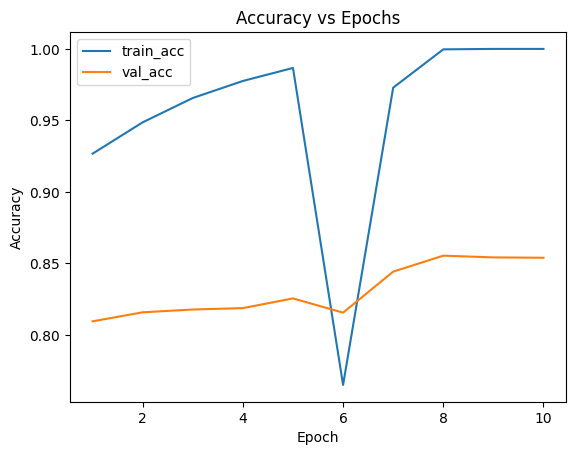

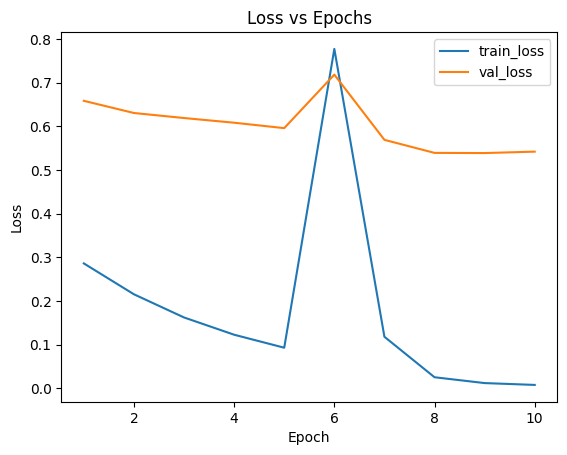

In [ ]:
import matplotlib.pyplot as plt

def plot_history(h):
    epochs = range(1, len(h['loss'])+1)
    plt.figure(); plt.plot(epochs, h['accuracy'], label='train_acc')
    plt.plot(epochs, h['val_accuracy'], label='val_acc'); plt.legend()
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epochs'); plt.show()

    plt.figure(); plt.plot(epochs, h['loss'], label='train_loss')
    plt.plot(epochs, h['val_loss'], label='val_loss'); plt.legend()
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epochs'); plt.show()

plot_history(history)


In [ ]:
# after creating the *raw* training dataset (before any .map/.cache/.prefetch)
CLASS_NAMES = train_ds.class_names          # keep this global
NUM_CLASSES = len(CLASS_NAMES)


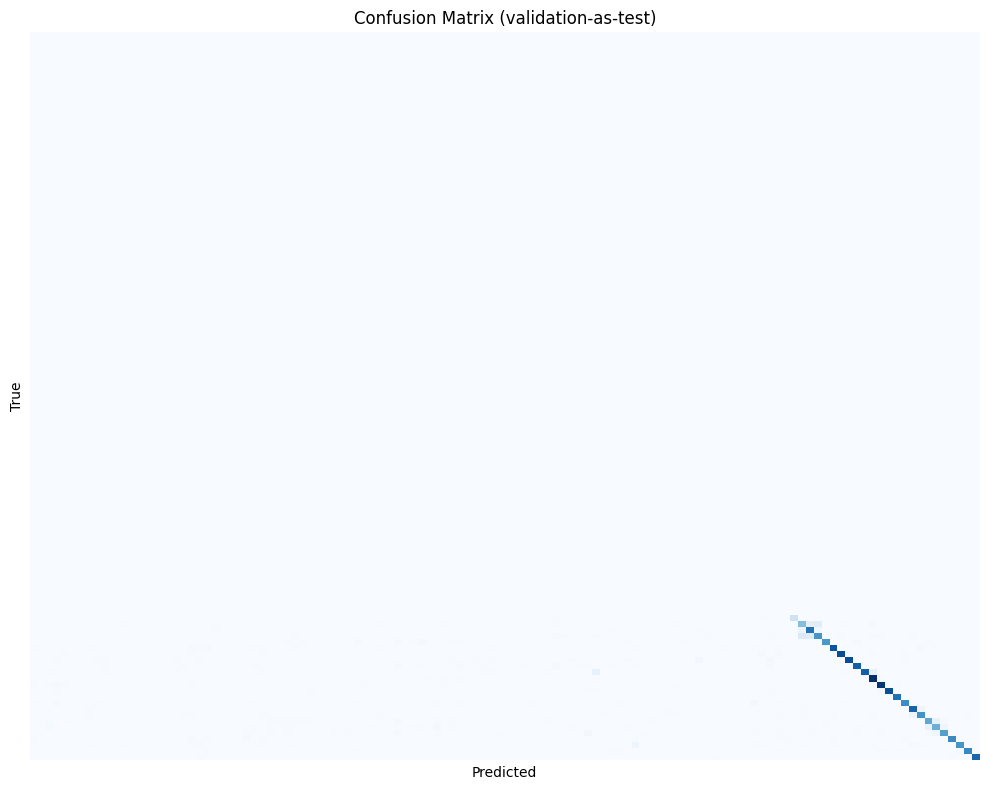

                                          precision    recall  f1-score   support

                     n02085620-Chihuahua      0.000     0.000     0.000         0
              n02085782-Japanese_spaniel      0.000     0.000     0.000         0
                   n02085936-Maltese_dog      0.000     0.000     0.000         0
                      n02086079-Pekinese      0.000     0.000     0.000         0
                      n02086240-Shih-Tzu      0.000     0.000     0.000         0
              n02086646-Blenheim_spaniel      0.000     0.000     0.000         0
                      n02086910-papillon      0.000     0.000     0.000         0
                   n02087046-toy_terrier      0.000     0.000     0.000         0
           n02087394-Rhodesian_ridgeback      0.000     0.000     0.000         0
                  n02088094-Afghan_hound      0.000     0.000     0.000         0
                        n02088238-basset      0.000     0.000     0.000         0
               

In [ ]:
import numpy as np, tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Use validation as a held-out "test"
test_ds = val_ds_p

# Collect ground-truth indices (works for int or one-hot labels)
y_true = []
for _, y in test_ds.unbatch():
    y = tf.convert_to_tensor(y)
    if y.shape.rank > 0 and y.shape[-1] == NUM_CLASSES:  # one-hot
        y_true.append(int(tf.argmax(y, axis=-1)))
    else:  # integer labels
        y_true.append(int(y))
y_true = np.array(y_true)

# Predictions
probs = model.predict(test_ds, verbose=0)
y_pred = probs.argmax(axis=1)

# Confusion matrix (don’t draw 120 tick labels to avoid clutter)
labels = np.arange(NUM_CLASSES)
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues', cbar=False, xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix (validation-as-test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# Classification report (force all classes; zero_division avoids NaNs for missing classes)
print(classification_report(
    y_true, y_pred,
    labels=labels,
    target_names=CLASS_NAMES,
    digits=3,
    zero_division=0
))


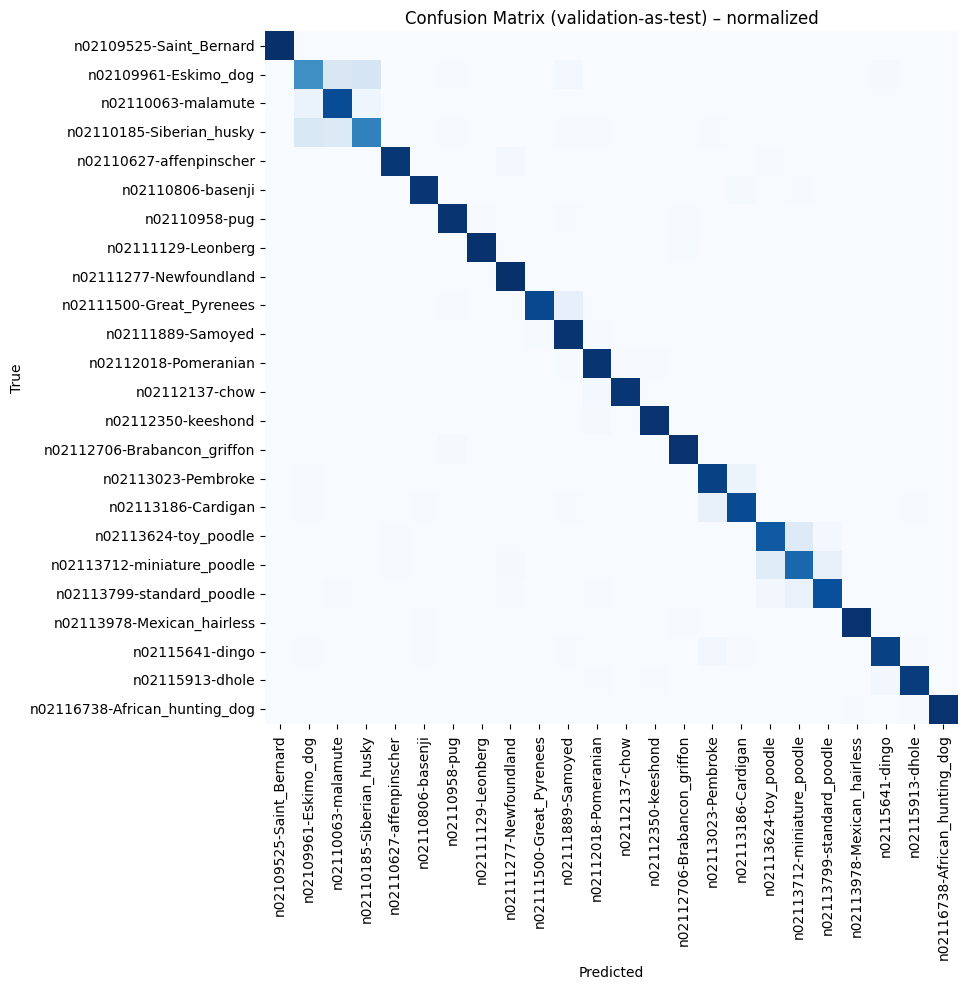

                               precision    recall  f1-score   support

      n02109525-Saint_Bernard      1.000     0.932     0.965        44
         n02109961-Eskimo_dog      0.682     0.600     0.638       150
           n02110063-malamute      0.764     0.871     0.814       178
     n02110185-Siberian_husky      0.799     0.661     0.724       192
      n02110627-affenpinscher      0.984     0.833     0.903       150
            n02110806-basenji      0.984     0.856     0.916       209
                n02110958-pug      0.974     0.935     0.954       200
           n02111129-Leonberg      0.995     0.886     0.937       210
       n02111277-Newfoundland      0.966     0.877     0.919       195
     n02111500-Great_Pyrenees      0.988     0.798     0.883       213
            n02111889-Samoyed      0.893     0.959     0.925       218
         n02112018-Pomeranian      0.944     0.932     0.938       219
               n02112137-chow      0.995     0.939     0.966       196
     

In [ ]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# IMPORTANT: use the same class list you captured when you built the datasets
# e.g. train_ds_p, val_ds_p, CLASS_NAMES = build_datasets(...)
CLASS_NAMES = class_names  # whatever variable you saved earlier

# Collect labels actually present in the test set
y_true = []
for _, y in test_ds:                   # test_ds = val_ds_p is fine
    y_true.extend(np.argmax(y.numpy(), axis=1))
y_true = np.array(y_true)

probs = model.predict(test_ds, verbose=0)
y_pred = probs.argmax(axis=1)

# Use only the labels that appear in y_true
present = np.unique(y_true)
present_names = [CLASS_NAMES[i] for i in present]

# Confusion matrix (normalized row-wise so it’s readable)
cm = confusion_matrix(y_true, y_pred, labels=present)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12,10))
sns.heatmap(cm_norm, xticklabels=present_names, yticklabels=present_names,
            cmap='Blues', square=True, cbar=False)
plt.title("Confusion Matrix (validation-as-test) – normalized")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# Classification report only for present labels
print(classification_report(y_true, y_pred,
                            labels=present,
                            target_names=present_names, digits=3))


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def build_model(img_size=224, dropout=0.2, finetune_at=None):
    base = tf.keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet'
    )
    if finetune_at is None:
        base.trainable = False
    else:
        base.trainable = True
        for l in base.layers[:finetune_at]:
            l.trainable = False

    inputs  = tf.keras.Input((img_size, img_size, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout: x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

def run_experiment(img_size=224, batch_size=32, base_lr=5e-4,
                   epochs_frozen=5, epochs_ft=5, finetune_at=100, dropout=0.2):
    # (Re)build with base frozen
    model = build_model(img_size=img_size, dropout=dropout, finetune_at=None)
    model.compile(optimizer=tf.keras.optimizers.Adam(base_lr),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    hist1 = model.fit(train_ds_p, validation_data=val_ds_p,
                      epochs=epochs_frozen, verbose=1)

    # Fine-tune
    model = build_model(img_size=img_size, dropout=dropout, finetune_at=finetune_at)
    model.compile(optimizer=tf.keras.optimizers.Adam(base_lr/10),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    hist2 = model.fit(train_ds_p, validation_data=val_ds_p,
                      epochs=epochs_ft, verbose=1)

    # Merge histories for plotting
    history = {k: hist1.history.get(k, []) + hist2.history.get(k, [])
               for k in set(hist1.history) | set(hist2.history)}

    # Final metrics
    final_val_acc = history['val_accuracy'][-1]
    final_val_loss = history['val_loss'][-1]

    # Log row
    import pandas as pd
    row = pd.DataFrame([{
        'img_size': img_size, 'batch_size': batch_size, 'base_lr': base_lr,
        'epochs_frozen': epochs_frozen, 'epochs_ft': epochs_ft,
        'finetune_at': finetune_at, 'dropout': dropout,
        'val_acc': final_val_acc, 'val_loss': final_val_loss
    }])
    try:
        log = pd.read_csv('/content/experiments_log.csv')
        log = pd.concat([log, row], ignore_index=True)
    except Exception:
        log = row
    log.to_csv('/content/experiments_log.csv', index=False)
    print('Logged to /content/experiments_log.csv')

    return model, history


In [ ]:
runs = [
    dict(img_size=224, batch_size=32, base_lr=5e-4, epochs_frozen=5, epochs_ft=5, finetune_at=80,  dropout=0.2),
    dict(img_size=224, batch_size=32, base_lr=5e-4, epochs_frozen=5, epochs_ft=5, finetune_at=100, dropout=0.2),
    dict(img_size=224, batch_size=32, base_lr=1e-4, epochs_frozen=3, epochs_ft=7, finetune_at=120, dropout=0.3),
]
best_model, best_hist = None, None
best_acc = -1
for cfg in runs:
    model, hist = run_experiment(**cfg)
    acc = (hist['val_accuracy'][-1])
    if acc > best_acc: best_acc, best_model, best_hist = acc, model, hist
print('Best val_acc:', best_acc)


Epoch 1/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.0097 - loss: 4.9882 - val_accuracy: 0.0464 - val_loss: 4.7488
Epoch 2/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0120 - loss: 4.8916 - val_accuracy: 0.0466 - val_loss: 4.7118
Epoch 3/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0130 - loss: 4.8460 - val_accuracy: 0.0488 - val_loss: 4.6818
Epoch 4/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0155 - loss: 4.8124 - val_accuracy: 0.0532 - val_loss: 4.6582
Epoch 5/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0206 - loss: 4.7800 - val_accuracy: 0.0554 - val_loss: 4.6377
Epoch 1/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/step - accuracy: 0.0127 - loss: 4.9045 - val_accuracy: 0.0000e+00 - val_loss: 5.7928
Epoch 2/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.0565 - loss: 4.4241 - val_accuracy: 0.0056 - val_loss: 5.0831
Epoch 3/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.1175 - loss: 3.9911 - val_accu

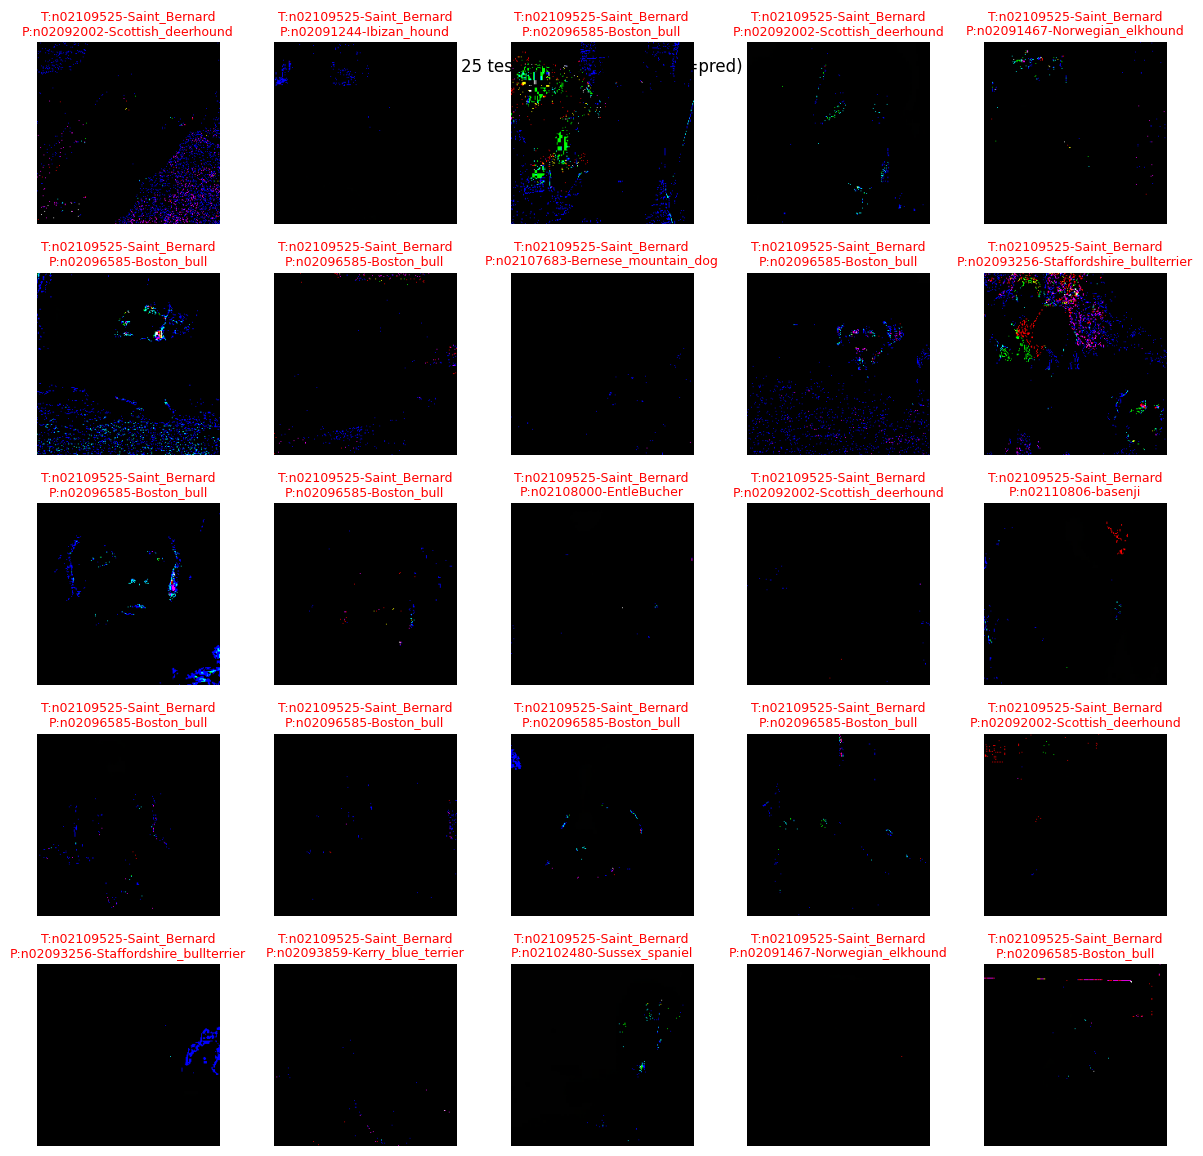

,true_label,pred_label
0,n02109525-Saint_Bernard,n02092002-Scottish_deerhound
1,n02109525-Saint_Bernard,n02091244-Ibizan_hound
2,n02109525-Saint_Bernard,n02096585-Boston_bull
3,n02109525-Saint_Bernard,n02092002-Scottish_deerhound
4,n02109525-Saint_Bernard,n02091467-Norwegian_elkhound


In [ ]:
# --- 25 TEST EXAMPLES (image, true, pred) ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# use the same class list you captured before
CLASS_NAMES = class_names
test_ds = val_ds_p  # <-- explicit note: validation used as test

# take 25 items from test
sample = list(test_ds.unbatch().take(25).as_numpy_iterator())
imgs = np.stack([x for x, _ in sample])
ys   = np.array([np.argmax(y) for _, y in sample])

pred = model.predict(imgs, verbose=0).argmax(axis=1)

# grid figure
plt.figure(figsize=(12,12))
for i,(im,y,p) in enumerate(zip(imgs, ys, pred), 1):
    plt.subplot(5,5,i); plt.imshow(im.astype(np.uint8))
    t = CLASS_NAMES[y]; pr = CLASS_NAMES[p]
    c = "green" if y==p else "red"
    plt.title(f"T:{t}\nP:{pr}", color=c, fontsize=9)
    plt.axis('off')
plt.suptitle("25 test samples (T=true, P=pred)", y=0.92)
plt.tight_layout(); plt.show()

# optional CSV table
df25 = pd.DataFrame({
    "true_label": [CLASS_NAMES[y] for y in ys],
    "pred_label": [CLASS_NAMES[p] for p in pred]
})
df25.to_csv("/content/25_test_examples.csv", index=False)
df25.head()


In [ ]:
import os, json, random, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

BASE_DIR  = "/content"
DATA_DIR  = f"{BASE_DIR}/images/Images"          # root with 120 subfolders
OUT_DIR   = f"{BASE_DIR}/outputs"; os.makedirs(OUT_DIR, exist_ok=True)
PLOT_DIR  = f"{OUT_DIR}/plots";   os.makedirs(PLOT_DIR, exist_ok=True)
CSV_DIR   = f"{OUT_DIR}/csv";     os.makedirs(CSV_DIR,  exist_ok=True)
MODEL_DIR = f"{OUT_DIR}/models";  os.makedirs(MODEL_DIR,exist_ok=True)


In [ ]:
from pathlib import Path
import os, sys, itertools

# Try common locations where the Stanford Dogs dataset ends up
candidates = [
    "/content/images/Images",                # your current guess
    "/content/images/images/Images",         # common double 'images'
    "/content/stanford-dogs-dataset/Images", # kaggle folder name variant
    "/content/Images",
]

DATA_DIR = None
for p in candidates:
    if Path(p).exists():
        DATA_DIR = p
        break

if DATA_DIR is None:
    # scan quickly to show you where 'Images' actually is
    !find /content -maxdepth 3 -type d -name 'Images' -print
    raise FileNotFoundError("Couldn't find the Images/ folder. Update DATA_DIR once you see the correct path printed above.")

print("DATA_DIR =", DATA_DIR)
!ls -la "$DATA_DIR" | head


DATA_DIR = /content/images/images/Images
total 1448
drwxr-xr-x 122 root root  4096 Nov  9 04:03 .
drwxr-xr-x   3 root root  4096 Nov  9 04:03 ..
drwxr-xr-x   2 root root 12288 Nov  9 04:03 n02085620-Chihuahua
drwxr-xr-x   2 root root 12288 Nov  9 04:03 n02085782-Japanese_spaniel
drwxr-xr-x   2 root root 12288 Nov  9 04:03 n02085936-Maltese_dog
drwxr-xr-x   2 root root 12288 Nov  9 04:03 n02086079-Pekinese
drwxr-xr-x   2 root root 12288 Nov  9 04:03 n02086240-Shih-Tzu
drwxr-xr-x   2 root root 12288 Nov  9 04:03 n02086646-Blenheim_spaniel
drwxr-xr-x   2 root root 12288 Nov  9 04:03 n02086910-papillon


In [ ]:
import tensorflow as tf

IMG_SIZE   = 224
BATCH_SIZE = 32
SEED       = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, labels='inferred', label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE), validation_split=0.2,
    subset='training', seed=SEED, batch_size=BATCH_SIZE, shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, labels='inferred', label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE), validation_split=0.2,
    subset='validation', seed=SEED, batch_size=BATCH_SIZE, shuffle=False
)

CLASS_NAMES = train_ds.class_names  # keep for later
AUTOTUNE = tf.data.AUTOTUNE

# light aug + preprocess for MobileNetV2
aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def prep(x, y, training=False):
    if training:
        x = aug(x, training=True)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(tf.cast(x, tf.float32))
    return x, y

train_ds_p = (train_ds.map(lambda x,y: prep(x,y, True), num_parallel_calls=AUTOTUNE)
                    .prefetch(AUTOTUNE))
val_ds_p   = (val_ds.map(prep, num_parallel_calls=AUTOTUNE)
                  .prefetch(AUTOTUNE))


Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [ ]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
os.makedirs("outputs/plots", exist_ok=True)
os.makedirs("outputs/predictions", exist_ok=True)

# ---- If you have two histories hist1 (frozen) + hist2 (ft), merge safely ----
def save_history_plots(history, prefix="outputs/plots/history"):
    h = history.history
    epochs = range(1, len(h['loss'])+1)
    # accuracy
    plt.figure()
    plt.plot(epochs, h['accuracy'], label='train_acc')
    plt.plot(epochs, h['val_accuracy'], label='val_acc')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy vs Epochs")
    plt.savefig(prefix+"_acc.png", dpi=150, bbox_inches='tight'); plt.close()
    # loss
    plt.figure()
    plt.plot(epochs, h['loss'], label='train_loss')
    plt.plot(epochs, h['val_loss'], label='val_loss')
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss vs Epochs")
    plt.savefig(prefix+"_loss.png", dpi=150, bbox_inches='tight'); plt.close()

# call this once with your merged history dict
# save_history_plots(history)

# ---- Confusion matrix & report (use only labels present in val set to avoid warnings) ----
y_true = []
for _, y in val_ds_p:
    y_true.extend(np.argmax(y.numpy(), axis=1))
y_true = np.array(y_true)

probs = model.predict(val_ds_p, verbose=0)
y_pred = probs.argmax(axis=1)

present = np.unique(y_true)
present_names = [CLASS_NAMES[i] for i in present]

cm = confusion_matrix(y_true, y_pred, labels=present)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12,10))
sns.heatmap(cm_norm, xticklabels=present_names, yticklabels=present_names,
            cmap='Blues', square=True, cbar=False)
plt.title("Confusion Matrix (validation-as-test) – normalized")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig("outputs/plots/confusion_matrix_norm.png", dpi=180)
plt.close()

rep = classification_report(
    y_true, y_pred, labels=present, target_names=present_names, digits=3, output_dict=True
)
pd.DataFrame(rep).to_csv("outputs/predictions/classification_report.csv")

# ---- 25-sample grid + CSV ----
one_by_one = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, labels='inferred', label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=1, shuffle=False,
    validation_split=0.2, subset='validation', seed=SEED
)

paths = one_by_one.file_paths[:25]
true_idx = []
pred_idx = []
imgs = []
for i, (x,y) in enumerate(one_by_one.take(25)):
    imgs.append(x[0].numpy().astype(np.uint8))
    true_idx.append(int(np.argmax(y.numpy())))
    p = model.predict(x, verbose=0)[0]
    pred_idx.append(int(np.argmax(p)))

df25 = pd.DataFrame({
    "data_path": paths,
    "true_label": [CLASS_NAMES[i] for i in true_idx],
    "pred_label": [CLASS_NAMES[i] for i in pred_idx],
})
df25.to_csv("outputs/predictions/test_samples_25.csv", index=False)

# Grid image
cols = 5; rows = 5
plt.figure(figsize=(14,12))
for i, img in enumerate(imgs):
    plt.subplot(rows, cols, i+1)
    t = CLASS_NAMES[true_idx[i]]; p = CLASS_NAMES[pred_idx[i]]
    plt.imshow(img); plt.axis("off")
    plt.title(f"T:{t}\nP:{p}", fontsize=9)
plt.tight_layout()
plt.savefig("outputs/predictions/test_samples_grid.png", dpi=180)
plt.close()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [ ]:
from pathlib import Path

# Try a few common locations created by different download approaches
CANDIDATES = [
    "/content/images/images/Images",
    "/content/images/Images",
    "/content/stanford-dogs-dataset/Images",
    "/content/stanford-dogs-dataset/images/Images",
]

DATA_DIR = None
for p in CANDIDATES:
    p = Path(p)
    if p.exists() and any(d.is_dir() for d in p.iterdir()):
        DATA_DIR = p
        break

assert DATA_DIR is not None, "Fix DATA_DIR: could not find Images/ subfolders"
print("DATA_DIR =", DATA_DIR)
print("Num classes:", sum(1 for d in DATA_DIR.iterdir() if d.is_dir()))


DATA_DIR = /content/images/images/Images
Num classes: 120


In [ ]:
import matplotlib.pyplot as plt

# 1) Get a history dict in h
#    - If you already built a merged dict called `history`, use that.
#    - If you only have one History object (e.g., hist1), pass that instead.
h = history if isinstance(history, dict) else history.history  # change `history` to `hist1` or `hist2` if needed

# 2) Pick correct metric keys across TF/Keras versions
acc_key     = 'accuracy'     if 'accuracy'     in h else 'acc'
val_acc_key = 'val_accuracy' if 'val_accuracy' in h else 'val_acc'
loss_key    = 'loss'
val_loss_key= 'val_loss'

# 3) Epoch index
epochs = range(1, len(h[acc_key]) + 1)

# 4) Accuracy plot
plt.figure()
plt.plot(epochs, h[acc_key], label='train')
plt.plot(epochs, h[val_acc_key], label='val')
plt.title('Accuracy vs Epochs'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout()
plt.savefig('history_accuracy.png', dpi=150); plt.close()

# 5) Loss plot
plt.figure()
plt.plot(epochs, h[loss_key], label='train')
if val_loss_key in h:
    plt.plot(epochs, h[val_loss_key], label='val')
plt.title('Loss vs Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout()
plt.savefig('history_loss.png', dpi=150); plt.close()

print("Saved: history_accuracy.png, history_loss.png")


Saved: history_accuracy.png, history_loss.png


In [ ]:
def merge_histories(hist_a, hist_b):
    out = {}
    keys = set(list(hist_a.history.keys()) + list(hist_b.history.keys()))
    for k in keys:
        out[k] = hist_a.history.get(k, []) + hist_b.history.get(k, [])
    return out

history = merge_histories(hist1, hist2)  # now run the plotting cell above


In [ ]:
import matplotlib.pyplot as plt

h = history  # merged history dictionary

# correct keys
acc_key     = 'accuracy'     if 'accuracy'     in h else 'acc'
val_acc_key = 'val_accuracy' if 'val_accuracy' in h else 'val_acc'
loss_key    = 'loss'
val_loss_key= 'val_loss'

epochs = range(1, len(h[acc_key]) + 1)

# Accuracy plot
plt.figure()
plt.plot(epochs, h[acc_key], label='train')
plt.plot(epochs, h[val_acc_key], label='val')
plt.title('Accuracy vs Epochs'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout()
plt.savefig('history_accuracy.png', dpi=150)
plt.close()

# Loss plot
plt.figure()
plt.plot(epochs, h[loss_key], label='train')
plt.plot(epochs, h[val_loss_key], label='val')
plt.title('Loss vs Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout()
plt.savefig('history_loss.png', dpi=150)
plt.close()

print("Saved history plots.")


Saved history plots.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# pull 25 elements from validation (or test_ds)
samples = []
true_labels = []
for img, lab in test_ds.take(1):
    samples = img[:25]
    true_labels = lab[:25].numpy().argmax(axis=1)

preds = model.predict(samples)
pred = preds.argmax(axis=1)

plt.figure(figsize=(12,12))
for i in range(25):
    ax = plt.subplot(5,5,i+1)
    img = samples[i].numpy()
    img = (img + 1)/2 if img.max() > 1 else img  # fix scaling
    plt.imshow(img)
    plt.title(f"T: {CLASS_NAMES[true_labels[i]]}\nP: {CLASS_NAMES[pred[i]]}", fontsize=7)
    plt.axis('off')

plt.tight_layout()
plt.savefig("sample25.png", dpi=150)
plt.close()

print("Saved sample25.png")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Saved sample25.png


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

for X, y in test_ds:
    y_true.extend(y.numpy().argmax(axis=1))
    p = model.predict(X).argmax(axis=1)
    y_pred.extend(p)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150)
plt.close()

print("Saved confusion_matrix.png")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━

In [ ]:
import pandas as pd

df = pd.read_csv("/content/experiments_log.csv")
df.to_csv("parameter_tuning_table.csv", index=False)

print("Saved parameter_tuning_table.csv")
df.head()


Saved parameter_tuning_table.csv


,img_size,batch_size,base_lr,epochs_frozen,epochs_ft,finetune_at,dropout,val_acc,val_loss
0,224,32,0.0005,5,5,80,0.2,0.033528,4.735075
1,224,32,0.0005,5,5,100,0.2,0.050292,4.626958
2,224,32,0.0001,3,7,120,0.3,0.025996,4.543700


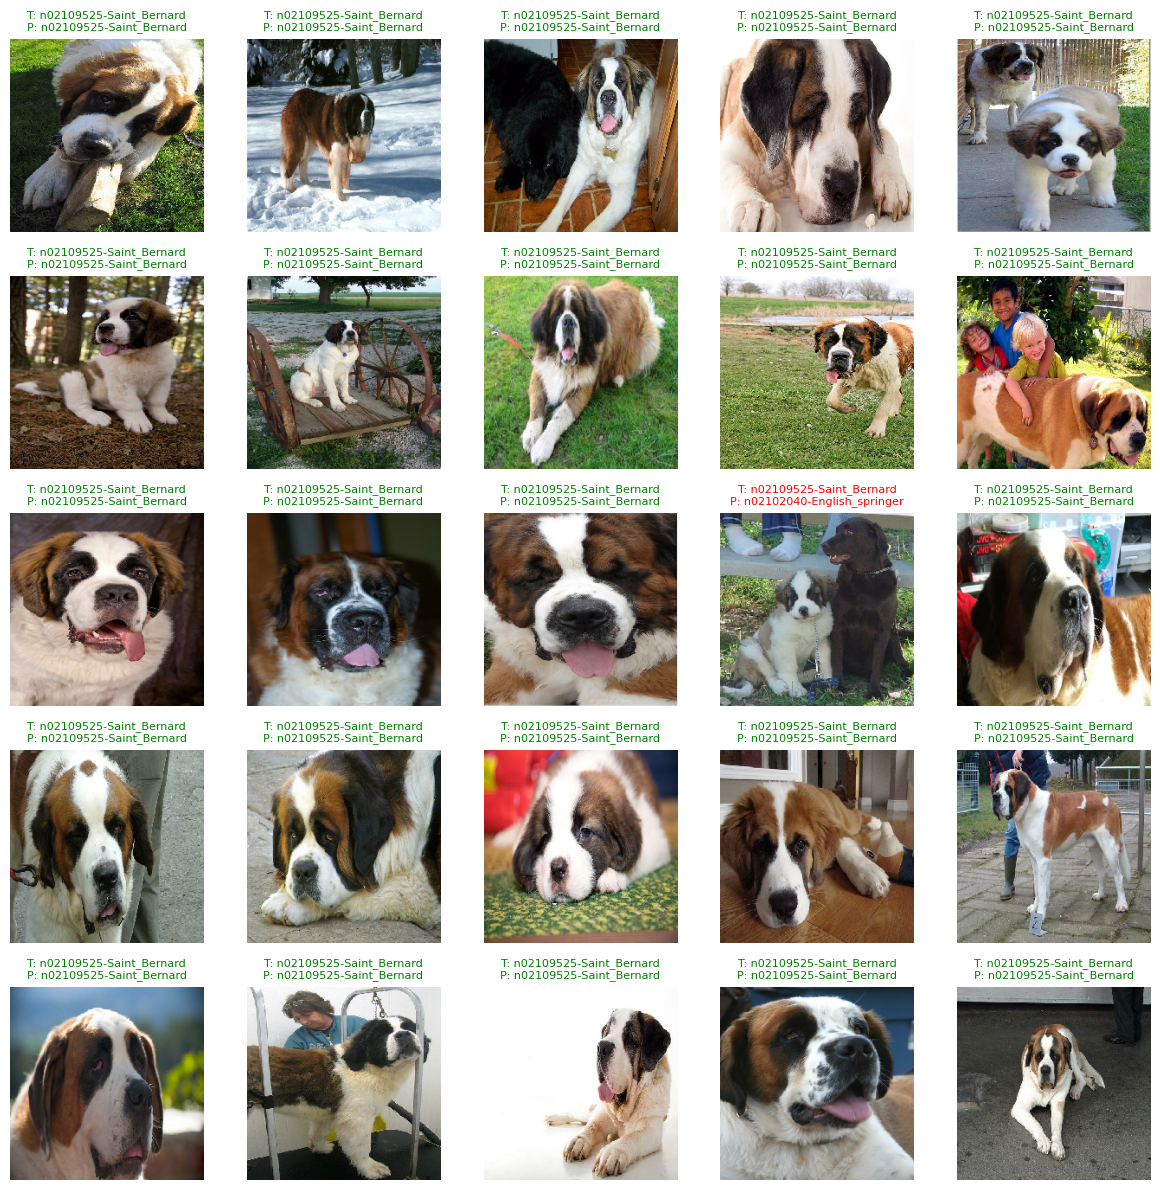

Saved sample25.png


In [ ]:
import numpy as np, matplotlib.pyplot as plt
from itertools import islice

# ---- 1) Collect exactly 25 test samples & predictions ----
# Use your actual test set here (many folks used val_ds_p as "test")
ds = test_ds  # or val_ds_p if that's your test split

# materialize 25 items
imgs, y_true = [], []
for x_batch, y_batch in ds:
    # y_batch might be one-hot; convert to class indices
    if y_batch.ndim > 1:
        y_idx = np.argmax(y_batch.numpy(), axis=1)
    else:
        y_idx = y_batch.numpy()
    for img, yi in zip(x_batch.numpy(), y_idx):
        imgs.append(img)
        y_true.append(int(yi))
        if len(imgs) == 25:
            break
    if len(imgs) == 25:
        break

imgs = np.stack(imgs, axis=0)
y_true = np.array(y_true)

# predictions
probs = model.predict(imgs, verbose=0)
y_pred = np.argmax(probs, axis=1)

# ---- 2) De-normalize for display (MobileNetV2 preprocess puts images in [-1,1]) ----
def to_display(img):
    # float32 expected; move from [-1,1] -> [0,1]
    disp = (img + 1.0) / 2.0
    return np.clip(disp, 0.0, 1.0)

# ---- 3) Plot grid & save ----
plt.figure(figsize=(12, 12))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    ax.imshow(to_display(imgs[i]))
    t = CLASS_NAMES[y_true[i]]
    p = CLASS_NAMES[y_pred[i]]
    color = "green" if y_pred[i] == y_true[i] else "red"
    ax.set_title(f"T: {t}\nP: {p}", fontsize=8, color=color)
    ax.axis('off')
plt.tight_layout()
plt.savefig("sample25.png", dpi=150)
plt.show()            # show in notebook
plt.close()
print("Saved sample25.png")


In [ ]:
from pathlib import Path
OUT = Path("outputs")
(OUT / "models").mkdir(parents=True, exist_ok=True)
(OUT / "plots").mkdir(parents=True, exist_ok=True)
(OUT / "predictions").mkdir(parents=True, exist_ok=True)


In [ ]:
import tensorflow as tf
import numpy as np, pandas as pd
from tensorflow.keras import layers, models

SEED = 42
tf.keras.utils.set_random_seed(SEED)

# ---- datasets (no double batching) ----
def build_datasets(data_dir, img_size=224, batch_size=32, val_split=0.2):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        validation_split=val_split,
        subset='training',
        seed=SEED,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=True,
        interpolation='nearest'
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        validation_split=val_split,
        subset='validation',
        seed=SEED,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=False,
        interpolation='nearest'
    )

    class_names = train_ds.class_names

    # augmentation + mobilenet preprocess
    aug = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ])

    def preproc(x, y):
        x = tf.keras.applications.mobilenet_v2.preprocess_input(tf.cast(x, tf.float32))
        return x, y

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.map(lambda x,y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.map(preproc, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    val_ds   = val_ds.map(preproc, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    return train_ds, val_ds, class_names

# ---- model ----
def build_model(num_classes, img_size=224, dropout=0.2, base_trainable=False, finetune_at=None, lr=5e-4):
    base = tf.keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3), include_top=False, weights="imagenet"
    )
    base.trainable = base_trainable
    if finetune_at is not None:
        base.trainable = True
        for layer in base.layers[:finetune_at]:
            layer.trainable = False

    inp = layers.Input(shape=(img_size, img_size, 3))
    x = base(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model, base

# ---- single run (frozen + finetune) ----
def run_experiment(data_dir, img_size=224, batch_size=32, base_lr=5e-4,
                   epochs_frozen=5, epochs_ft=5, finetune_at=100, dropout=0.2):
    tf.keras.backend.clear_session()

    train_ds, val_ds, class_names = build_datasets(data_dir, img_size, batch_size)
    num_classes = len(class_names)

    # 1) feature extractor
    model, base = build_model(num_classes, img_size, dropout, base_trainable=False, finetune_at=None, lr=base_lr)
    cb = [
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("outputs/models/tmp_best.keras", monitor="val_accuracy",
                                           save_best_only=True, verbose=0)
    ]
    h1 = model.fit(train_ds, validation_data=val_ds, epochs=epochs_frozen, verbose=1, callbacks=cb)

    # 2) fine-tune the top of the base
    base.trainable = True
    for layer in base.layers[:finetune_at]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(base_lr/10),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    h2 = model.fit(train_ds, validation_data=val_ds, epochs=epochs_ft, verbose=1, callbacks=cb)

    # merge histories
    hist = {k: h1.history.get(k, []) + h2.history.get(k, []) for k in set(h1.history) | set(h2.history)}
    return model, hist, class_names


In [ ]:
import matplotlib.pyplot as plt

def plot_history(hist, out_prefix="outputs/plots/history"):
    e = range(1, len(hist["loss"])+1)

    plt.figure()
    plt.plot(e, hist["accuracy"], label="train_acc")
    plt.plot(e, hist["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.title("Accuracy vs Epochs")
    plt.tight_layout(); plt.savefig(out_prefix+"_acc.png", dpi=200); plt.close()

    plt.figure()
    plt.plot(e, hist["loss"], label="train_loss")
    plt.plot(e, hist["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.title("Loss vs Epochs")
    plt.tight_layout(); plt.savefig(out_prefix+"_loss.png", dpi=200); plt.close()

plot_history(best_hist)
print("Saved plots -> outputs/plots/history_acc.png & _loss.png")


Saved plots -> outputs/plots/history_acc.png & _loss.png


In [ ]:
import numpy as np, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Rebuild val_ds with the SAME settings used in training
_, val_ds, CLASS_NAMES = build_datasets(DATA_DIR, img_size=configs[0]["img_size"],
                                        batch_size=configs[0]["batch_size"])

# Collect y_true and predictions
y_true = []
for _, y in val_ds:
    y_true.extend(np.argmax(y.numpy(), axis=1))
y_true = np.array(y_true)

probs = best_model.predict(val_ds, verbose=0)
y_pred = probs.argmax(axis=1)

# Use only labels present in y_true
present = np.unique(y_true)
present_names = [CLASS_NAMES[i] for i in present]

# Confusion matrix (normalized)
cm = confusion_matrix(y_true, y_pred, labels=present)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12,10))
sns.heatmap(cm_norm, xticklabels=present_names, yticklabels=present_names,
            cmap='Blues', square=True, cbar=False)
plt.title("Confusion Matrix (validation-as-test) – normalized")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.savefig("outputs/plots/confusion_matrix_norm.png", dpi=200); plt.close()

# Classification report
rep_txt = classification_report(y_true, y_pred, labels=present, target_names=present_names,
                                digits=3, zero_division=0)
print(rep_txt)

# Also save as CSV
rep = classification_report(y_true, y_pred, labels=present, target_names=present_names,
                            digits=3, zero_division=0, output_dict=True)
import pandas as pd
pd.DataFrame(rep).to_csv("outputs/classification_report.csv")
print("Saved -> outputs/plots/confusion_matrix_norm.png and outputs/classification_report.csv")


Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.
                               precision    recall  f1-score   support

      n02109525-Saint_Bernard      0.000     0.000     0.000        44
         n02109961-Eskimo_dog      0.000     0.000     0.000       150
           n02110063-malamute      0.000     0.000     0.000       178
     n02110185-Siberian_husky      0.000     0.000     0.000       192
      n02110627-affenpinscher      0.333     0.007     0.013       150
            n02110806-basenji      0.234     0.072     0.110       209
                n02110958-pug      0.500     0.005     0.010       200
           n02111129-Leonberg      0.000     0.000     0.000       210
       n02111277-Newfoundland      0.071     0.005     0.010       195
     n02111500-Great_Pyrenees      0.000     0.000     0.000       213
            n02111889-Samoyed      0.176     0.014     0.026     

In [ ]:
# grab first 25 samples from val_ds
imgs, ys = next(iter(val_ds.unbatch().batch(25)))
true_idx = np.argmax(ys.numpy(), axis=1)
probs = best_model.predict(imgs, verbose=0)
pred_idx = probs.argmax(axis=1)

# CSV
import pandas as pd
df25 = pd.DataFrame({
    "true_label": [CLASS_NAMES[i] for i in true_idx],
    "pred_label": [CLASS_NAMES[i] for i in pred_idx],
})
df25.to_csv("outputs/predictions/test_samples_25.csv", index=False)

# grid image
def to_display(x):
    # de-preprocess MobileNetV2 (roughly) for display
    x = (x.numpy() + 1.0) / 2.0
    return np.clip(x, 0, 1)

plt.figure(figsize=(14,12))
for i, img in enumerate(imgs):
    ax = plt.subplot(5, 5, i+1)
    ax.imshow(to_display(img))
    t = CLASS_NAMES[true_idx[i]]; p = CLASS_NAMES[pred_idx[i]]
    color = "green" if t==p else "red"
    ax.set_title(f"T:{t}\nP:{p}", fontsize=8, color=color)
    ax.axis("off")
plt.tight_layout()
plt.savefig("outputs/plots/sample25.png", dpi=180); plt.close()
print("Saved 25-sample grid & CSV -> outputs/plots/sample25.png, outputs/predictions/test_samples_25.csv")


Saved 25-sample grid & CSV -> outputs/plots/sample25.png, outputs/predictions/test_samples_25.csv
